# EnergyML - Production Cycle Analysis

This notebook demonstrates the full workflow of the EnergyML project, which is designed to analyze energy consumption time-series data from industrial machines.

The goal is to:
- Detect machine operational states
- Segment production cycles based on energy thresholds
- Evaluate cycle quality and detect anomalies
- Aggregate production data over time
- Derive insights to improve efficiency and detect irregular behavior

---

## 📥 Step 1: Load the data

The first step is to load and preprocess the energy data using the script `data_loader.py`.  
This script handles timestamp parsing, sorting, and initial cleaning of the raw input file.


In [253]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Ensure the parent directory is in the path to import the module
sys.path.append(os.path.abspath(".."))

# Importing the MachineDataLoader from the energy_ml package
# If the import fails, ensure the package structure is correct and the module exists
from energy_ml.data_loader import MachineDataLoader

loader = MachineDataLoader("../data/raw/Datadump.txt")

df = loader.load_data()
df_clean = loader.preprocess()

df_clean.head()


,timestamp,value
0,2025-05-11 07:08:49.154,25.96
1,2025-05-11 07:08:49.413,26.21
2,2025-05-11 07:08:49.672,25.99
3,2025-05-11 07:08:49.931,25.83
4,2025-05-11 07:08:52.017,26.23


In [254]:
df_clean

,timestamp,value
0,2025-05-11 07:08:49.154,25.96000
1,2025-05-11 07:08:49.413,26.21000
2,2025-05-11 07:08:49.672,25.99000
3,2025-05-11 07:08:49.931,25.83000
4,2025-05-11 07:08:52.017,26.23000
...,...,...
197221,2025-05-12 08:08:45.874,44.79000
197222,2025-05-12 08:08:48.206,68.00000
197223,2025-05-12 08:08:48.465,71.90000
197224,2025-05-12 08:08:48.724,74.51000


In [255]:
# Basic statistics of the 'value' column
df_clean["value"].describe()


count    196886.000000
mean         37.953831
std          29.295578
min           0.789999
25%          26.100000
50%          26.240000
75%          26.550000
max         369.780000
Name: value, dtype: float64

In [256]:
# Calculate quartiles and interquartile range (IQR)
Q1 = df_clean["value"].quantile(0.25)
Q2 = df_clean["value"].quantile(0.50)  # Median
Q3 = df_clean["value"].quantile(0.75)
IQR = Q3 - Q1

# Define outlier boundaries
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Print results
print(f"Q1: {Q1:.2f}, Q2 (median): {Q2:.2f}, Q3: {Q3:.2f}")
print(f"Lower bound (outliers): {lower_bound:.2f}")
print(f"Upper bound (outliers): {upper_bound:.2f}")


Q1: 26.10, Q2 (median): 26.24, Q3: 26.55
Lower bound (outliers): 25.43
Upper bound (outliers): 27.23


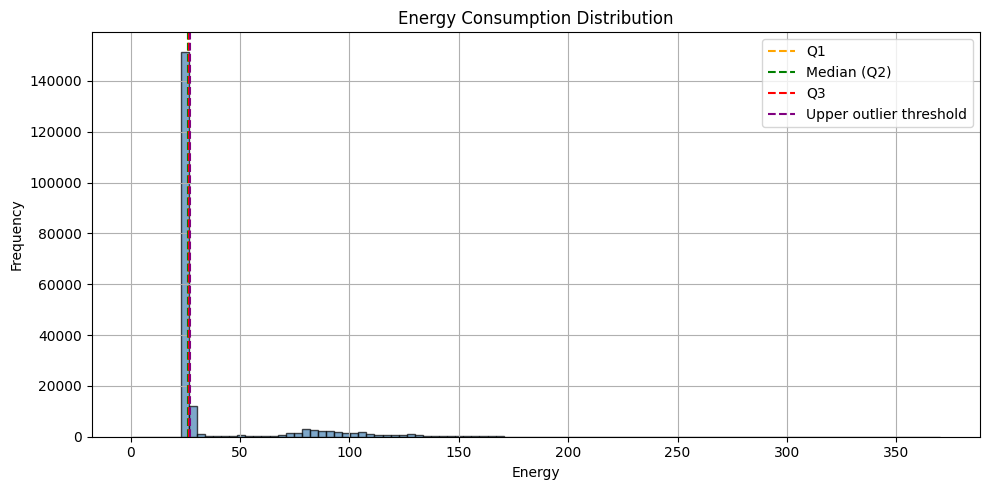

In [257]:
# Plotting the distribution of energy consumption
plt.figure(figsize=(10, 5))
plt.hist(df_clean["value"], bins=100, alpha=0.7, color='steelblue', edgecolor='k')
plt.axvline(Q1, color='orange', linestyle='--', label="Q1")
plt.axvline(Q2, color='green', linestyle='--', label="Median (Q2)")
plt.axvline(Q3, color='red', linestyle='--', label="Q3")
plt.axvline(upper_bound, color='purple', linestyle='--', label="Upper outlier threshold")
plt.title("Energy Consumption Distribution")
plt.xlabel("Energy")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

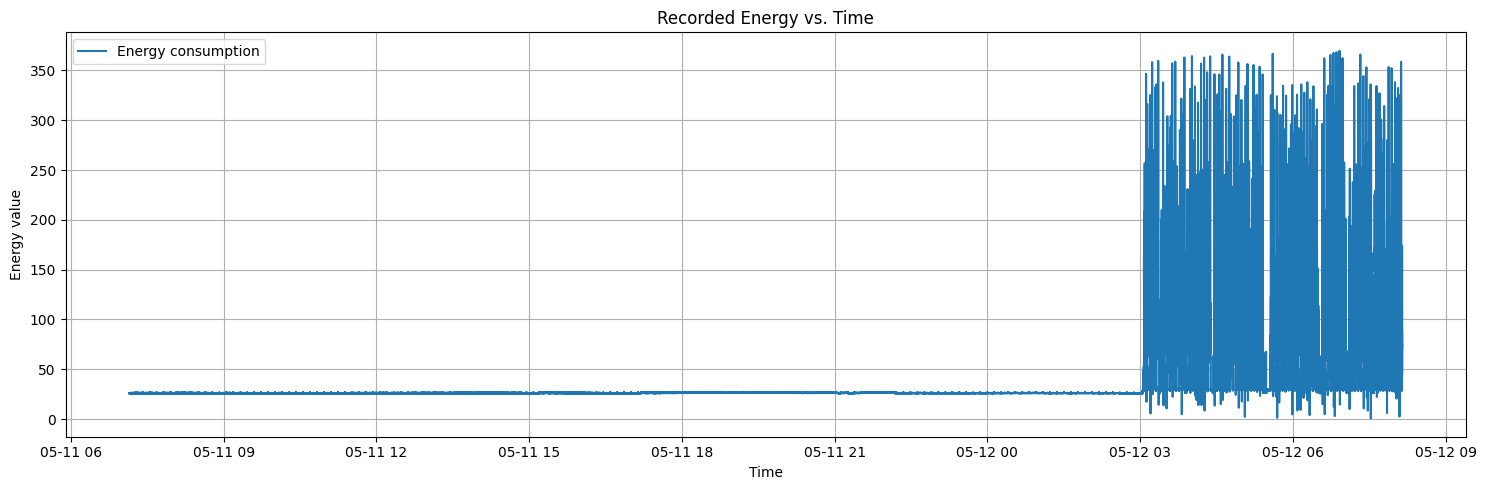

In [258]:
plt.figure(figsize=(15, 5))
plt.plot(df_clean["timestamp"], df_clean["value"], label="Energy consumption")
plt.xlabel("Time")
plt.ylabel("Energy value")
plt.title("Recorded Energy vs. Time")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


To better understand the distribution of low energy readings, we apply a zoomed-in histogram limited to the range between 0 and 20 units.  
This allows us to inspect the density and behavior of low-energy states, such as standby, startup, or potentially idle periods that are not visible in the full-range plot.


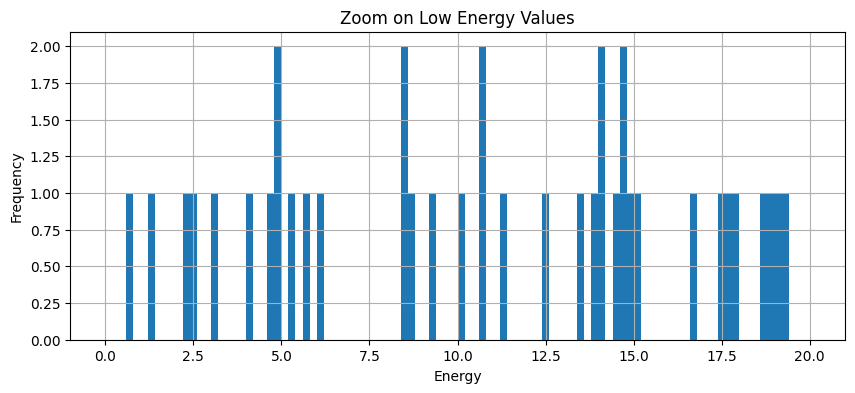

In [259]:
df_clean["value"].hist(bins=100, figsize=(10, 4), range=(0, 20))
plt.title("Zoom on Low Energy Values")
plt.xlabel("Energy")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()



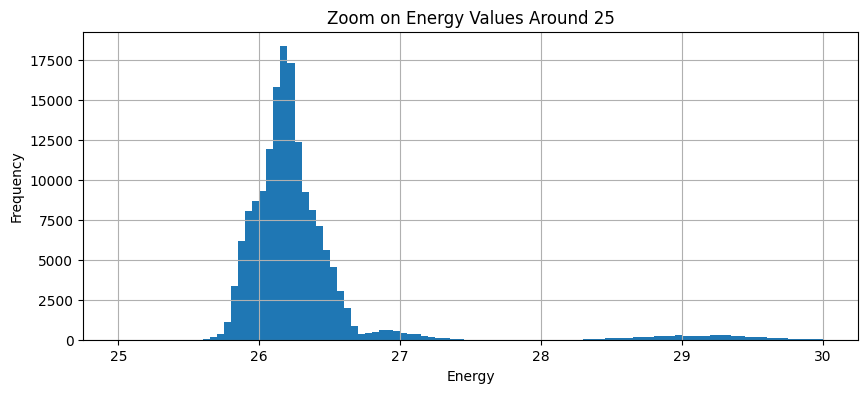

In [260]:
df_clean["value"].hist(bins=100, figsize=(10, 4), range=(25, 30))
plt.title("Zoom on Energy Values Around 25")
plt.xlabel("Energy")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


This plot zooms in on the energy values between 20 and 30 units to analyze states that may correspond to **standby or idle conditions**.  
These intermediate values are useful to distinguish transitions between low-energy states and full production.

From this analysis, we conclude that values in this range are likely indicative of **standby behavior**, where the machine is powered but not actively producing.


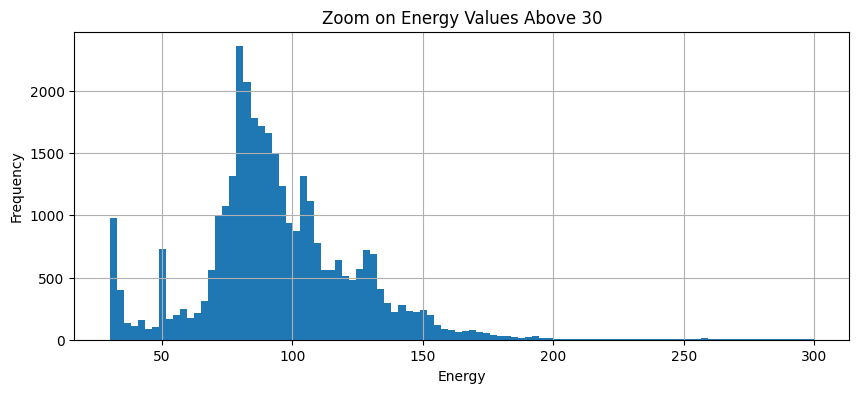

In [261]:
df_clean["value"].hist(bins=100, figsize=(10, 4), range=(30, 300))
plt.title("Zoom on Energy Values Above 30")
plt.xlabel("Energy")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


This plot zooms in on energy values above 28 units, which are likely associated with **active production cycles**.  
The distribution in this range helps us understand the variability in production intensity and duration.

From this analysis, we conclude that values above 28 represent typical energy consumption during **normal or abnormal production**, depending on how far they deviate from expected operating ranges.


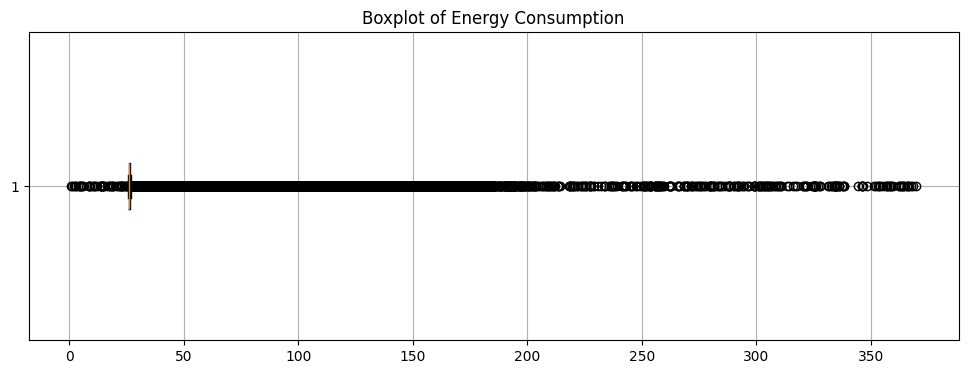

In [262]:
plt.figure(figsize=(12, 4))
plt.boxplot(df_clean["value"], vert=False)
plt.title("Boxplot of Energy Consumption")
plt.grid(True)
plt.show()


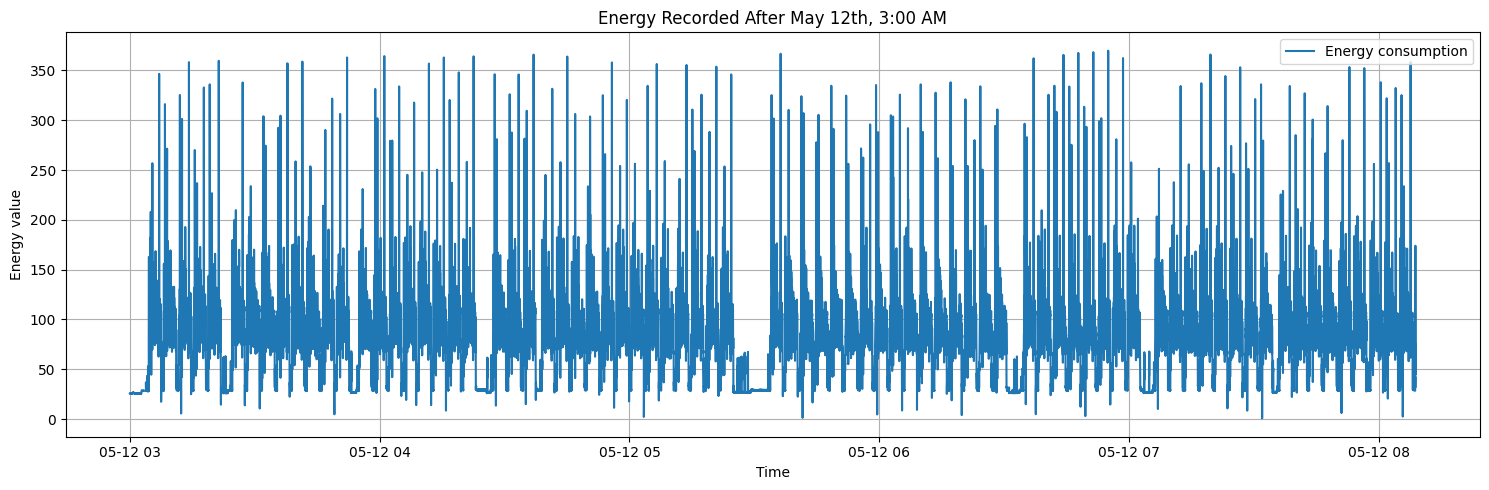

In [263]:

# Filter data after May 12th at 3:00 AM
start_time = pd.Timestamp("2025-05-12 03:00:00")
df_after = df_clean[df_clean["timestamp"] > start_time]

plt.figure(figsize=(15, 5))
plt.plot(df_after["timestamp"], df_after["value"], label="Energy consumption")
plt.xlabel("Time")
plt.ylabel("Energy value")
plt.title("Energy Recorded After May 12th, 3:00 AM")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



To focus on a specific period, we filter the time series to include only data recorded after May 12th at 3:00 AM.  
This allows for a more detailed inspection of recent machine behavior and production activity.


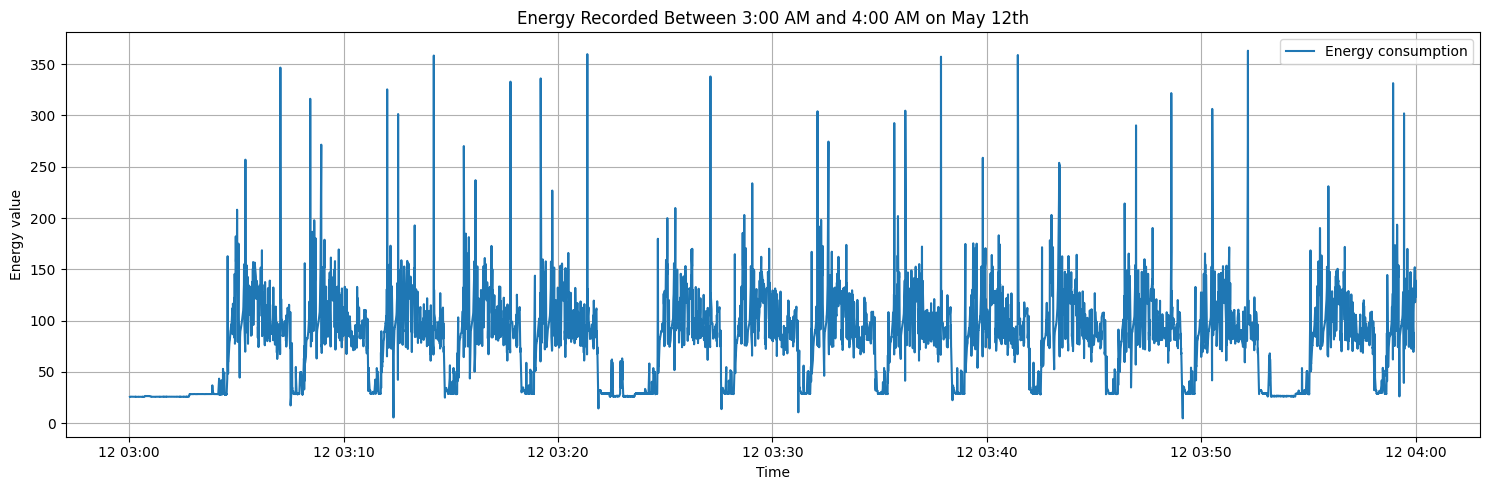

In [264]:
# Filter data between May 12th, 3:00 AM and 4:00 AM
start = pd.Timestamp("2025-05-12 03:00:00")
end = pd.Timestamp("2025-05-12 04:00:00")
df_3to4 = df_clean[(df_clean["timestamp"] >= start) & (df_clean["timestamp"] < end)]

plt.figure(figsize=(15, 5))
plt.plot(df_3to4["timestamp"], df_3to4["value"], label="Energy consumption")
plt.xlabel("Time")
plt.ylabel("Energy value")
plt.title("Energy Recorded Between 3:00 AM and 4:00 AM on May 12th")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


This plot focuses on a one-hour window between 3:00 AM and 4:00 AM on May 12th.  
Zooming into a narrow time range helps examine short-term fluctuations and detect specific production events or anomalies.



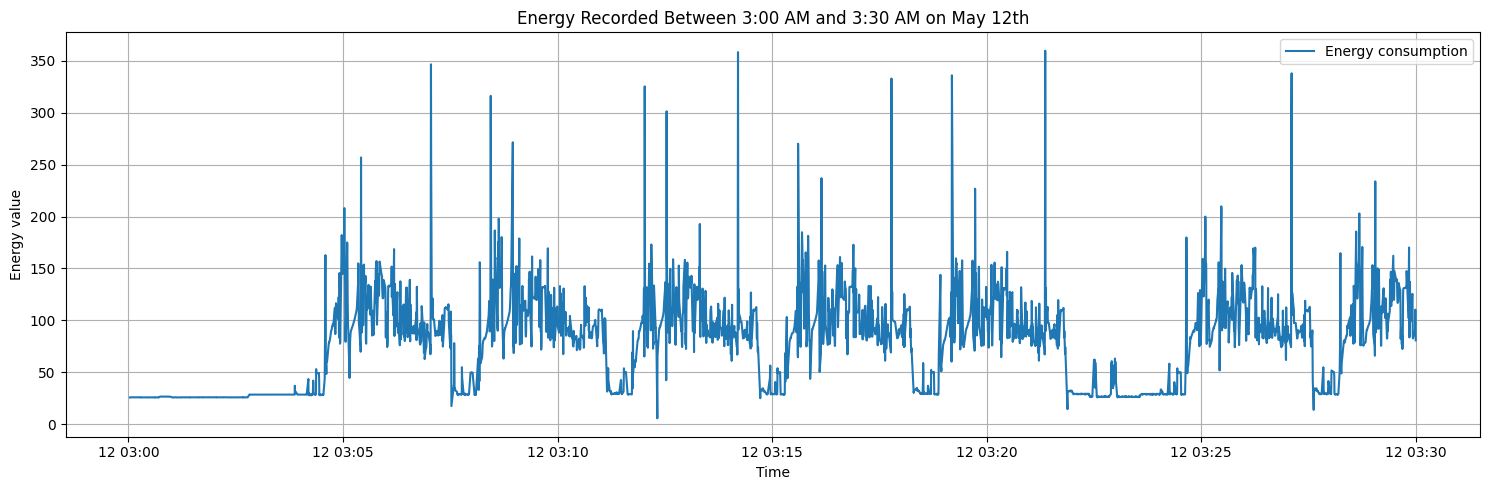

In [265]:
# Filter data between May 12th, 3:00 AM and 3:30 AM
start = pd.Timestamp("2025-05-12 03:00:00")
end = pd.Timestamp("2025-05-12 03:30:00")
df_3to330 = df_clean[(df_clean["timestamp"] >= start) & (df_clean["timestamp"] < end)]

plt.figure(figsize=(15, 5))
plt.plot(df_3to330["timestamp"], df_3to330["value"], label="Energy consumption")
plt.xlabel("Time")
plt.ylabel("Energy value")
plt.title("Energy Recorded Between 3:00 AM and 3:30 AM on May 12th")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [266]:
from energy_ml.Functions import StateDetector

detector = StateDetector(df_clean, n_states=5)
df_clustered = detector.classify_states()
df_clustered.head()


g:\My Drive\Documentos Juan Felipe\Technical Assessment\energy_ml_project\energy_ml\Functions.py:41: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["rolling_mean"] = df["rolling_mean"].fillna(method='bfill').fillna(method='ffill')


,timestamp,value,state_cluster
0,2025-05-11 07:08:49.154,25.96,0
1,2025-05-11 07:08:49.413,26.21,0
2,2025-05-11 07:08:49.672,25.99,0
3,2025-05-11 07:08:49.931,25.83,0
4,2025-05-11 07:08:52.017,26.23,0


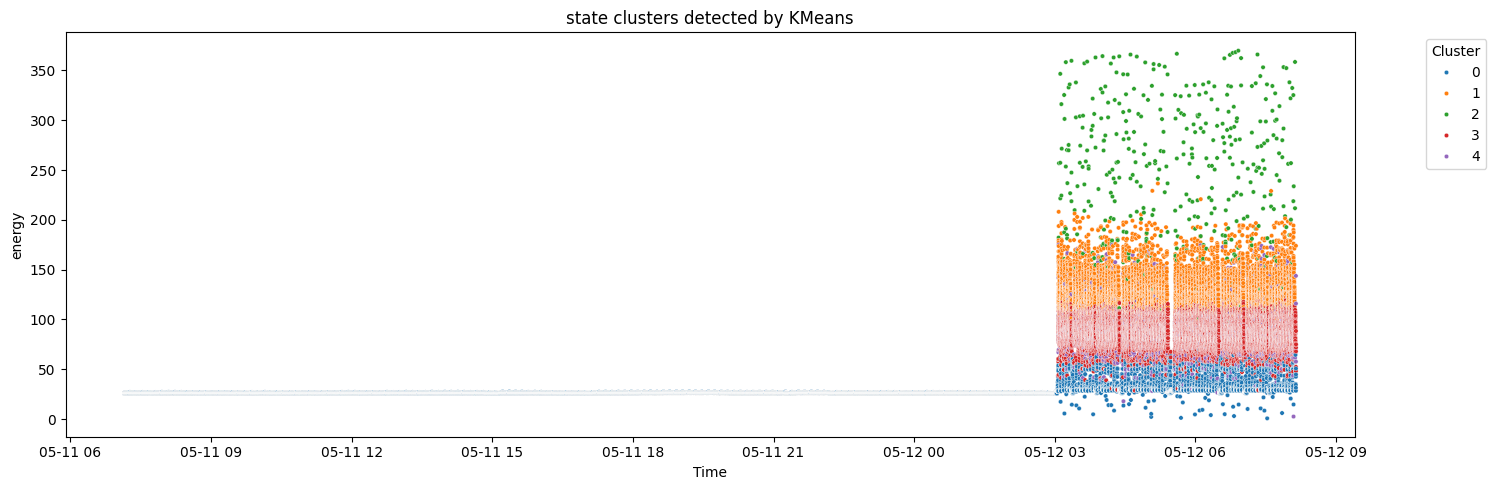

In [267]:
# Plotting the clusters detected by KMeans
plt.figure(figsize=(15, 5))
sns.scatterplot(data=df_clustered, x="timestamp", y="value", hue="state_cluster", palette="tab10", s=10)
plt.title("state clusters detected by KMeans")
plt.xlabel("Time")
plt.ylabel("energy")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


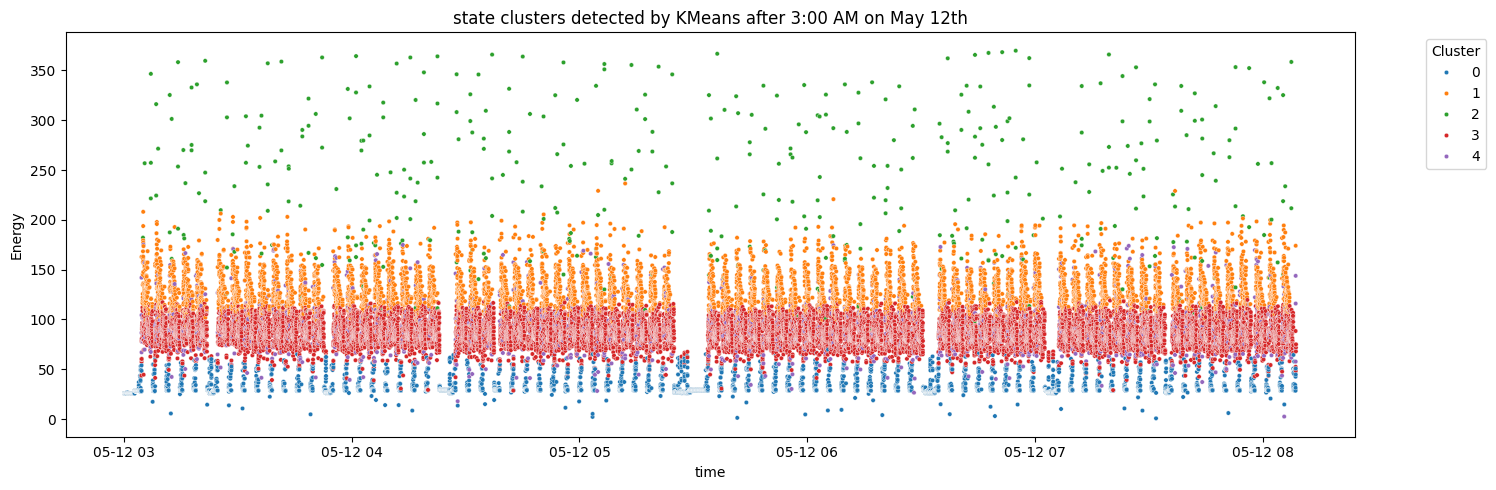

In [268]:
start = pd.Timestamp("2025-05-12 03:00:00")
df_3a4_Clustered = df_clustered[(df_clustered["timestamp"] >= start)]


plt.figure(figsize=(15, 5))
sns.scatterplot(data=df_3a4_Clustered, x="timestamp", y="value", hue="state_cluster", palette="tab10", s=10)
plt.title("state clusters detected by KMeans after 3:00 AM on May 12th")
plt.xlabel("time")
plt.ylabel("Energy")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


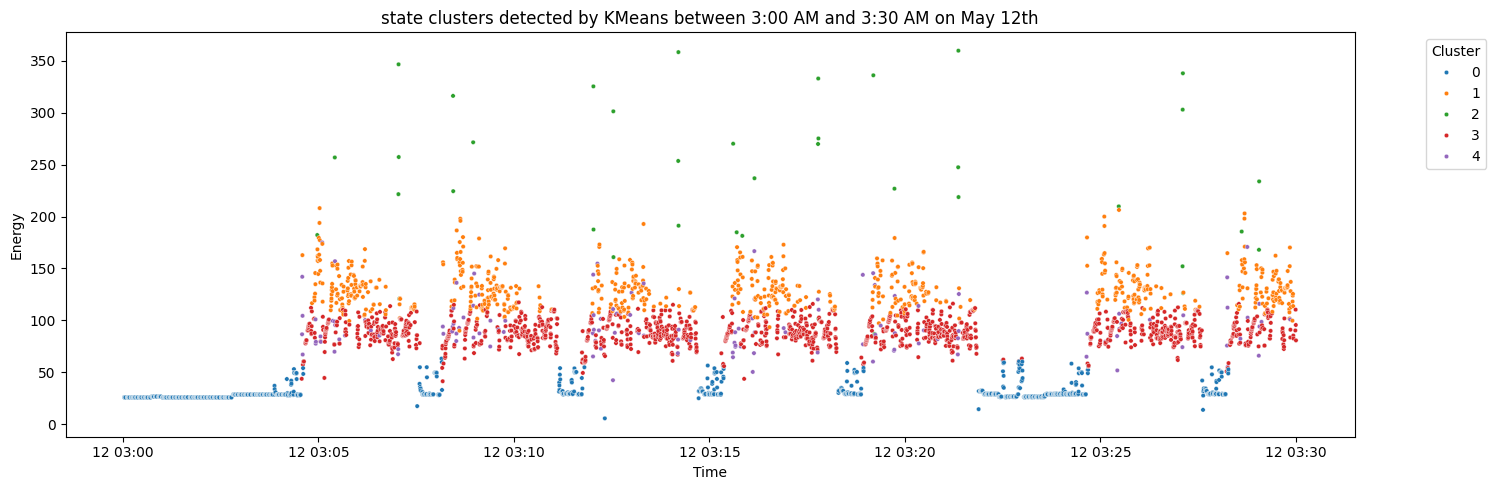

In [269]:
start = pd.Timestamp("2025-05-12 03:00:00")
end = pd.Timestamp("2025-05-12 03:30:00")
df_3a4_Clustered = df_clustered[(df_clustered["timestamp"] >= start) & (df_clustered["timestamp"] < end)]


plt.figure(figsize=(15, 5))
sns.scatterplot(data=df_3a4_Clustered, x="timestamp", y="value", hue="state_cluster", palette="tab10", s=10)
plt.title("state clusters detected by KMeans between 3:00 AM and 3:30 AM on May 12th")
plt.xlabel("Time")
plt.ylabel("Energy")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


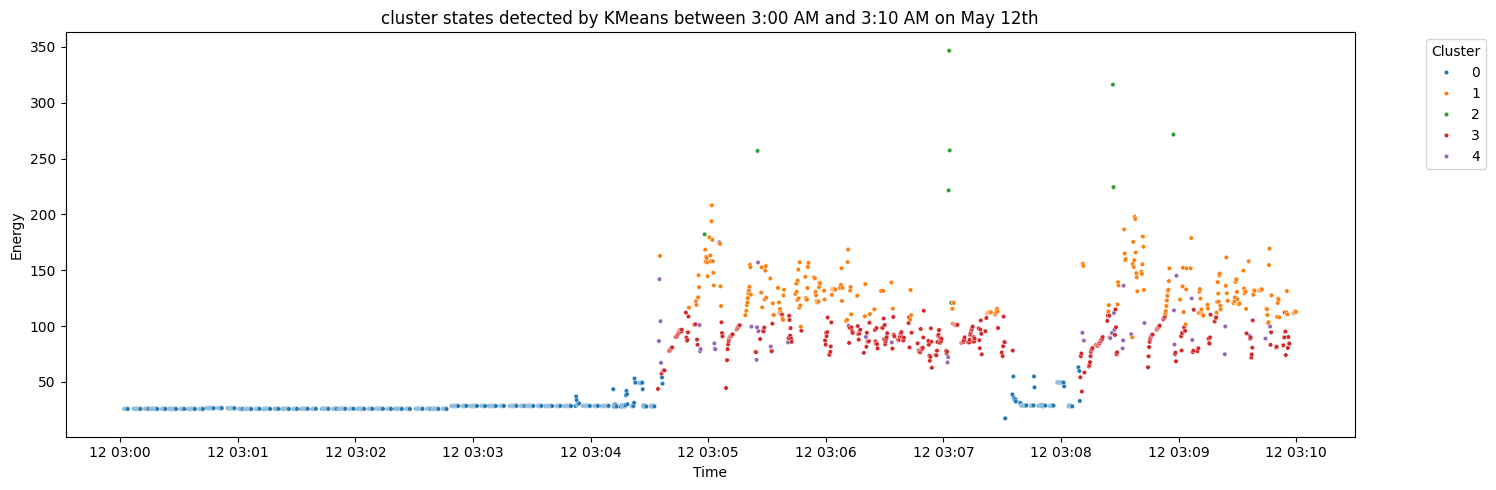

In [270]:
start = pd.Timestamp("2025-05-12 03:00:00")
end = pd.Timestamp("2025-05-12 03:10:00")
df_3a4_Clustered = df_clustered[(df_clustered["timestamp"] >= start) & (df_clustered["timestamp"] < end)]


plt.figure(figsize=(15, 5))
sns.scatterplot(data=df_3a4_Clustered, x="timestamp", y="value", hue="state_cluster", palette="tab10", s=10)
plt.title("cluster states detected by KMeans between 3:00 AM and 3:10 AM on May 12th")
plt.xlabel("Time")
plt.ylabel("Energy")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

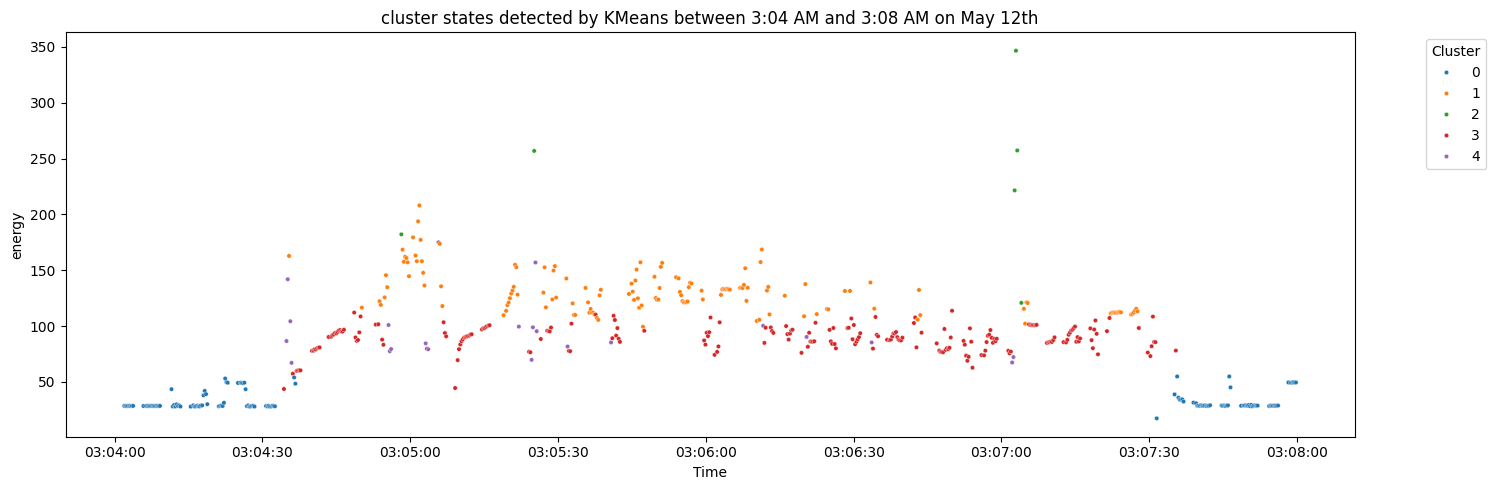

In [271]:
start = pd.Timestamp("2025-05-12 03:04:00")
end = pd.Timestamp("2025-05-12 03:08:00")
df_3a4_Clustered = df_clustered[(df_clustered["timestamp"] >= start) & (df_clustered["timestamp"] < end)]


plt.figure(figsize=(15, 5))
sns.scatterplot(data=df_3a4_Clustered, x="timestamp", y="value", hue="state_cluster", palette="tab10", s=10)
plt.title("cluster states detected by KMeans between 3:04 AM and 3:08 AM on May 12th")
plt.xlabel("Time")
plt.ylabel("energy")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## 🧾 Conclusion: Why I Chose a Rule-Based Model Over Clustering

After testing the KMeans-based state detection model (`StateDetector`), I found that the clustering results did not align well with the expected behavior of the machine.

Specifically:
- The distribution of cluster assignments did **not include any zero values**, which in theory should represent an "Off" state.
- Additionally, there were **few points between 0 and 25**, which would normally be expected in "On" or "Standby" states.

This suggested that the clustering model was heavily influenced by the dominant range of energy values and failed to capture low-energy behaviors accurately. In other words, the model appeared **biased** due to the unbalanced distribution of the data.

As a result, I decided to implement a **rule-based classification**, informed by both:
- My domain knowledge of the system, and  
- The observed structure of the energy data.

The rules used were:

```python
def classify(value):
    if value == 0:
        return "Off"
    elif 0 < value <= 20:
        return "On"
    elif 20 < value <= 30:
        return "Standby"
    elif 30 < value <= 150:
        return "Normal Production"
    else:
        return "Abnormal Production"


In [272]:
from energy_ml.Functions import RuleBasedStateDetector

rule_detector = RuleBasedStateDetector(df_clean)
df_states_rule = rule_detector.classify_states()

# Verifica los resultados
df_states_rule["state"].value_counts()
df_states_rule[["timestamp", "value", "state"]].head()


,timestamp,value,state
0,2025-05-11 07:08:49.154,25.96,Standby
1,2025-05-11 07:08:49.413,26.21,Standby
2,2025-05-11 07:08:49.672,25.99,Standby
3,2025-05-11 07:08:49.931,25.83,Standby
4,2025-05-11 07:08:52.017,26.23,Standby


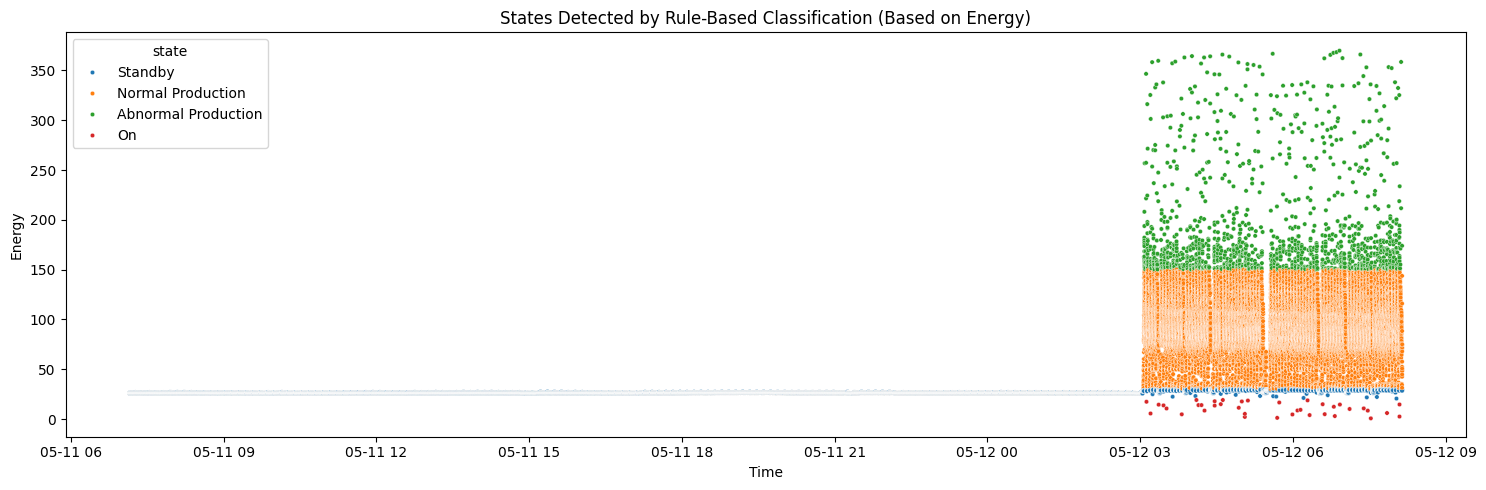

In [273]:
plt.figure(figsize=(15, 5))
sns.scatterplot(data=df_states_rule, x="timestamp", y="value", hue="state", palette="tab10", s=10)
plt.title("States Detected by Rule-Based Classification (Based on Energy)")
plt.xlabel("Time")
plt.ylabel("Energy")
plt.tight_layout()
plt.show()

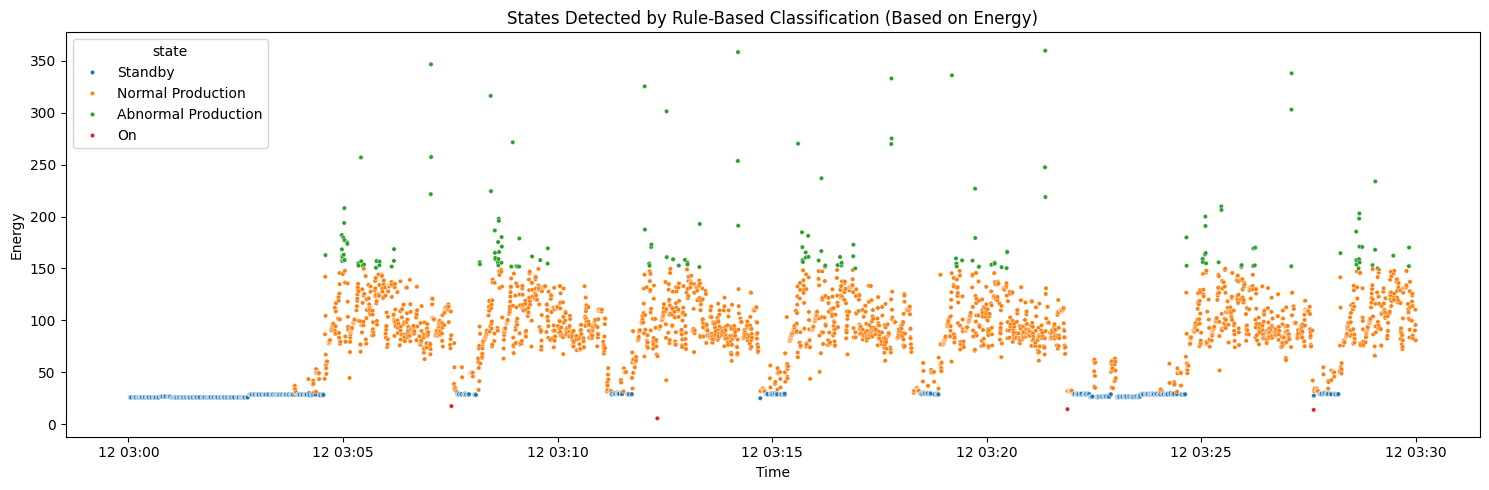

In [274]:
# Filter data between 3:00 AM and 3:30 AM on May 12
start = pd.Timestamp("2025-05-12 03:00:00")
end = pd.Timestamp("2025-05-12 03:30:00")
df_3to330_clustered = df_states_rule[(df_states_rule["timestamp"] >= start) & (df_states_rule["timestamp"] < end)]

plt.figure(figsize=(15, 5))
sns.scatterplot(data=df_3to330_clustered, x="timestamp", y="value", hue="state", palette="tab10", s=10)
plt.title("States Detected by Rule-Based Classification (Based on Energy)")
plt.xlabel("Time")
plt.ylabel("Energy")
plt.tight_layout()
plt.show()


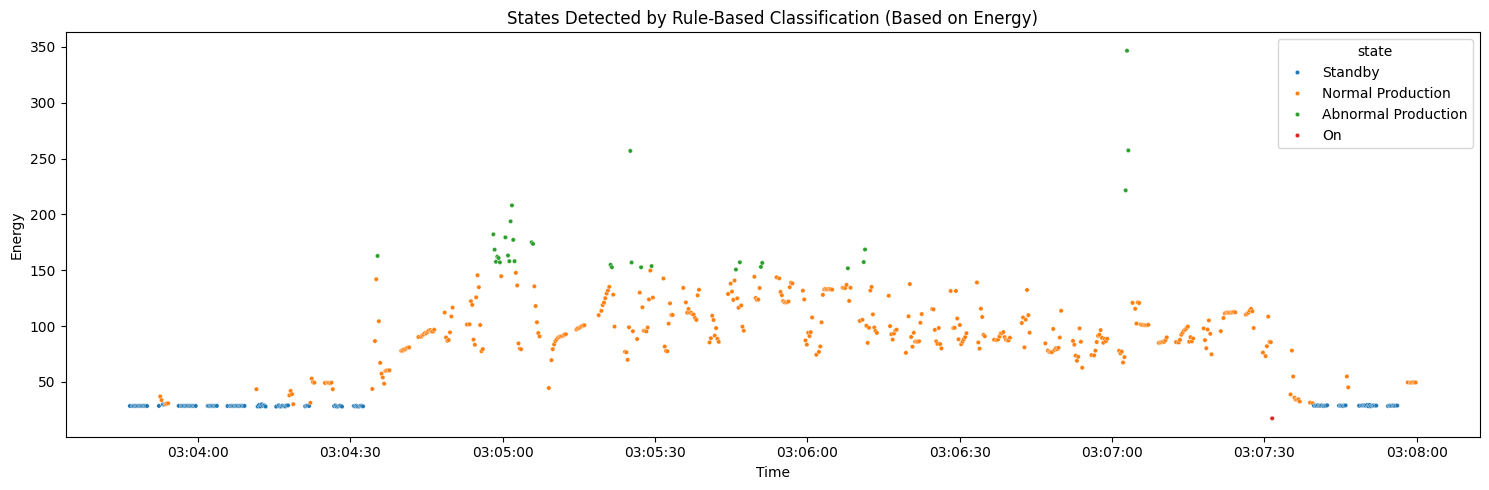

In [275]:
# Filter data between 3:03:45 AM and 3:08:00 AM on May 12
start = pd.Timestamp("2025-05-12 03:03:45")
end = pd.Timestamp("2025-05-12 03:08:00")
df_window = df_states_rule[(df_states_rule["timestamp"] >= start) & (df_states_rule["timestamp"] < end)]

plt.figure(figsize=(15, 5))
sns.scatterplot(data=df_window, x="timestamp", y="value", hue="state", palette="tab10", s=10)
plt.title("States Detected by Rule-Based Classification (Based on Energy)")
plt.xlabel("Time")
plt.ylabel("Energy")
plt.tight_layout()
plt.show()


## 🔄 Segmenting Product Cycles Based on Energy Signal

To identify individual production cycles, we use the `segment_product_cycles()` function.

This function scans the time series and labels segments where the energy value remains **above a certain threshold** (e.g., 30.0) for at least a **minimum duration** (e.g., 50 consecutive data points). These parameters help filter out noise and short fluctuations that do not represent actual production.

### How it works:
- A new column called `'active'` is created to flag whether the machine is considered "on" at each point in time (`value > threshold`).
- The algorithm loops through the data and groups continuous active points into a **cycle**, assigning a unique `cycle_id` to each.
- If the detected active sequence is **shorter than `min_duration`**, it is discarded (cycle ID not assigned).
- The output is the same DataFrame with a new column `'cycle_id'` indicating which points belong to a valid production cycle (0 = no cycle).

This approach is useful when you want to extract high-confidence operating periods that represent full production runs.


In [276]:
from energy_ml.Functions import segment_product_cycles

segmented_df = segment_product_cycles(
    df_states_rule, 
    energy_col="value", 
    threshold=30.0, 
    min_duration=50
)


In [277]:
segmented_df 

,timestamp,value,state,cycle_id
0,2025-05-11 07:08:49.154,25.96000,Standby,0
1,2025-05-11 07:08:49.413,26.21000,Standby,0
2,2025-05-11 07:08:49.672,25.99000,Standby,0
3,2025-05-11 07:08:49.931,25.83000,Standby,0
4,2025-05-11 07:08:52.017,26.23000,Standby,0
...,...,...,...,...
197221,2025-05-12 08:08:45.874,44.79000,Normal Production,99
197222,2025-05-12 08:08:48.206,68.00000,Normal Production,99
197223,2025-05-12 08:08:48.465,71.90000,Normal Production,99
197224,2025-05-12 08:08:48.724,74.51000,Normal Production,99


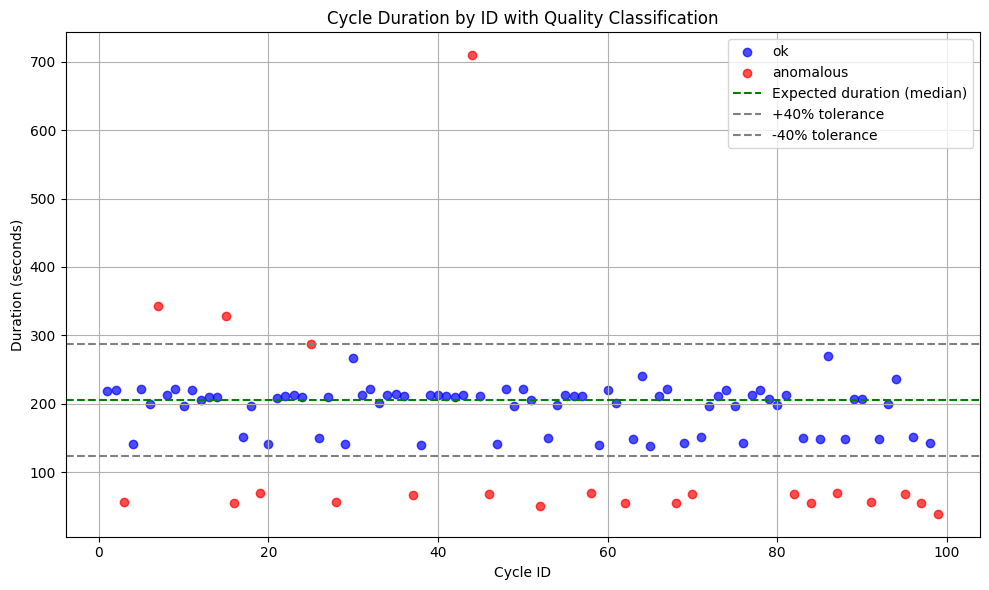

In [278]:
# Ensure the 'timestamp' column is in datetime format
segmented_df["timestamp"] = pd.to_datetime(segmented_df["timestamp"])

# Group the DataFrame by each cycle to calculate its start and end time
df_cycles = segmented_df[segmented_df["cycle_id"] > 0].groupby("cycle_id").agg(
    start_time=("timestamp", "first"),
    end_time=("timestamp", "last")
).reset_index()

# Calculate the duration of each cycle in seconds
df_cycles["duration_sec"] = (df_cycles["end_time"] - df_cycles["start_time"]).dt.total_seconds()

# Compute the expected duration (median) and define a tolerance range
expected_duration = df_cycles["duration_sec"].median()
tolerance = 0.4  # 40% tolerance

# Evaluate the quality of each cycle
# A cycle is labeled 'anomalous' if its duration deviates more than 40% from the median
df_cycles["quality_flag"] = df_cycles["duration_sec"].apply(
    lambda d: "anomalous" if abs(d - expected_duration) > tolerance * expected_duration else "ok"
)

# Plot each cycle's duration with color-coded quality classification
plt.figure(figsize=(10, 6))
for label, color in zip(["ok", "anomalous"], ["blue", "red"]):
    subset = df_cycles[df_cycles["quality_flag"] == label]
    plt.scatter(subset["cycle_id"], subset["duration_sec"], label=label, color=color, alpha=0.7)

# Draw reference lines for expected duration and tolerance bounds
plt.axhline(expected_duration, color="green", linestyle="--", label="Expected duration (median)")
plt.axhline(expected_duration * (1 + tolerance), color="gray", linestyle="--", label="+40% tolerance")
plt.axhline(expected_duration * (1 - tolerance), color="gray", linestyle="--", label="-40% tolerance")
plt.title("Cycle Duration by ID with Quality Classification")
plt.xlabel("Cycle ID")
plt.ylabel("Duration (seconds)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## 📊 Counting Production Units per Time Period

Once the production cycles have been identified and labeled with `cycle_id`, we can analyze the production rate over time.

We use the function `count_units_by_period()` to count how many distinct cycles occurred during each time period.  
In this case, the frequency `"1H"` groups the data by hour.

### How it works:
- It filters only valid cycles (`cycle_id > 0`) and removes duplicate rows (each cycle may span multiple rows).
- The timestamp column is converted to datetime and set as the index.
- The data is resampled using the specified frequency (e.g., `"1H"` for hourly).
- The function counts the number of unique production cycles that started in each time period and returns a new DataFrame with:
  - The period (e.g., each hour)
  - The number of units produced (`units_produced`)

This allows us to track how production intensity varies over time.


In [279]:
from energy_ml.Functions import count_units_by_period

# Count number of production cycles per hour
units_hourly = count_units_by_period(segmented_df, time_col="timestamp", freq="1H")


g:\My Drive\Documentos Juan Felipe\Technical Assessment\energy_ml_project\energy_ml\Functions.py:152: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  count_by_period = df_cycles.resample(freq)["cycle_id"].count().rename("units_produced").reset_index()


In [284]:
units_hourly

,timestamp,units_produced
0,2025-05-12 03:00:00,17
1,2025-05-12 04:00:00,19
2,2025-05-12 05:00:00,17
3,2025-05-12 06:00:00,21
4,2025-05-12 07:00:00,20
5,2025-05-12 08:00:00,5


## 🧪 Evaluating Cycle Quality

To assess the consistency of production cycles, we use the `assess_cycle_quality()` function.

This function calculates the **duration** of each cycle and compares it to a reference value, typically the **median duration** across all cycles.

### How it works:
1. The function groups the data by `cycle_id` and calculates the start and end time for each cycle.
2. It computes the duration in seconds for each cycle.
3. If no expected duration is provided, it uses the **median** as the expected value.
4. It compares each cycle's duration to the expected duration.
   - If the deviation is **greater than 50%**, the cycle is flagged as `"anomalous"`.
   - Otherwise, it is considered `"ok"`.

The output is a new DataFrame (`quality_report`) with one row per cycle and a column `'quality_flag'` indicating whether the cycle duration is within acceptable limits.

This is useful for identifying irregular cycles that may signal mechanical issues, sensor noise, or process variation.


In [ ]:
from energy_ml.Functions import assess_cycle_quality

# Evaluate the quality of detected production cycles
quality_report = assess_cycle_quality(segmented_df, time_col="timestamp")

In [282]:
quality_report

,cycle_id,start_time,end_time,duration_sec,quality_flag
0,1,2025-05-12 03:03:52.598,2025-05-12 03:07:31.279,218.681,ok
1,2,2025-05-12 03:07:35.161,2025-05-12 03:11:14.636,219.475,ok
2,3,2025-05-12 03:11:22.681,2025-05-12 03:12:18.444,55.763,anomalous
3,4,2025-05-12 03:12:19.738,2025-05-12 03:14:40.584,140.846,ok
4,5,2025-05-12 03:14:43.695,2025-05-12 03:18:25.208,221.513,ok
...,...,...,...,...,...
94,95,2025-05-12 08:00:57.673,2025-05-12 08:02:06.146,68.473,anomalous
95,96,2025-05-12 08:02:07.757,2025-05-12 08:04:39.201,151.444,ok
96,97,2025-05-12 08:04:45.414,2025-05-12 08:05:40.646,55.232,anomalous
97,98,2025-05-12 08:05:43.766,2025-05-12 08:08:05.916,142.150,ok


<Axes: xlabel='quality_flag'>

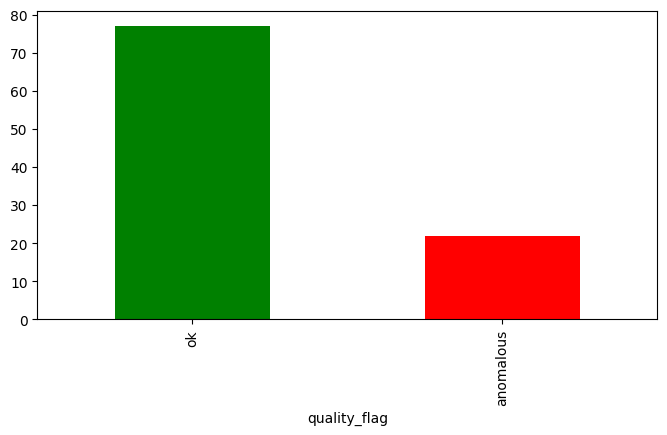

In [283]:
quality_report["quality_flag"].value_counts().plot(kind='bar', figsize=(8, 4), color=['green', 'red'])